In [ ]:
# AN EXAMPLE HOW ImageDataGenerator works

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('dogs_and_cats/demo2/11535.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='dogs_and_cats/demo2', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [ ]:
'''This script goes along the blog post
"Building powerful image classification models using very little data"
from blog.keras.io.  :
"https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html"

It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'dogs_and_cats/data_small/train'
validation_data_dir = 'dogs_and_cats/data_small/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

**Using the bottleneck features of a pre-trained network: 90% accuracy in a minute**

In [ ]:
'''This script goes along the blog post
"Building powerful image classification models using very little data"
from blog.keras.io.
"https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html"

It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'dogs_and_cats/data_small/bottleneck_fc_model.h5'
train_data_dir = 'dogs_and_cats/data_small/train'
validation_data_dir = 'dogs_and_cats/data_small/validation'
nb_train_samples = 20000
nb_validation_samples = 5000
epochs = 50
batch_size = 20 # was 16

if nb_train_samples % batch_size != 0:
    raise ArithmeticError(
        "nb_train_samples should be divisibe by batch_size.\n"
        "nb_train_samples is "+str(nb_train_samples)+", "
        "but batch_size is "+str(batch_size)+"."
    )
    
if nb_validation_samples % batch_size != 0:
    raise ArithmeticError(
        "nb_validation_samples should be divisibe by batch_size.\n"
        "nb_validation_samples is "+str(nb_validation_samples)+", "
        "but batch_size is "+str(batch_size)+"."
    )

def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('dogs_and_cats/data_small/bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('dogs_and_cats/data_small/bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)


def train_top_model():
    
    train_data = np.load(open('dogs_and_cats/data_small/bottleneck_features_train.npy', 'rb'))
    train_labels = np.array(
        [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))
    
    # print("train_data.shape: " + str(train_data.shape))
    # print("train_labels.shape: " + str(train_labels.shape))

    validation_data = np.load(open('dogs_and_cats/data_small/bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array(
        [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
    
    # print("validation_data.shape: " + str(validation_data.shape))
    # print("validation_labels.shape: " + str(validation_labels.shape))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)


save_bottlebeck_features()
train_top_model()

In [ ]:
## Big data

In [1]:
'''This script goes along the blog post
"Building powerful image classification models using very little data"
from blog.keras.io.
"https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html"

It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'dogs_and_cats/split_data/bottleneck_fc_model.h5'
train_data_dir = 'dogs_and_cats/split_data/train'
validation_data_dir = 'dogs_and_cats/split_data/validation'
nb_train_samples = 20000
nb_validation_samples = 5000
epochs = 50
batch_size = 20 # was 16

if nb_train_samples % batch_size != 0:
    raise ArithmeticError(
        "nb_train_samples should be divisibe by batch_size.\n"
        "nb_train_samples is "+str(nb_train_samples)+", "
        "but batch_size is "+str(batch_size)+"."
    )
    
if nb_validation_samples % batch_size != 0:
    raise ArithmeticError(
        "nb_validation_samples should be divisibe by batch_size.\n"
        "nb_validation_samples is "+str(nb_validation_samples)+", "
        "but batch_size is "+str(batch_size)+"."
    )

def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('dogs_and_cats/split_data/bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('dogs_and_cats/split_data/bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)


def train_top_model():
    
    train_data = np.load(open('dogs_and_cats/split_data/bottleneck_features_train.npy', 'rb'))
    train_labels = np.array(
        [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))
    
    # print("train_data.shape: " + str(train_data.shape))
    # print("train_labels.shape: " + str(train_labels.shape))

    validation_data = np.load(open('dogs_and_cats/split_data/bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array(
        [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
    
    # print("validation_data.shape: " + str(validation_data.shape))
    # print("validation_labels.shape: " + str(validation_labels.shape))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)


save_bottlebeck_features()
train_top_model()

Using TensorFlow backend.


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 10s - loss: 0.3863 - acc: 0.8477 - val_loss: 0.3327 - val_acc: 0.8752
Epoch 2/50
20000/20000 [==============================] - 10s - loss: 0.2797 - acc: 0.8906 - val_loss: 0.2517 - val_acc: 0.9006
Epoch 3/50
20000/20000 [==============================] - 9s - loss: 0.2558 - acc: 0.9019 - val_loss: 0.2427 - val_acc: 0.9108
Epoch 4/50
20000/20000 [==============================] - 9s - loss: 0.2406 - acc: 0.9087 - val_loss: 0.2734 - val_acc: 0.9064
Epoch 5/50
20000/20000 [==============================] - 9s - loss: 0.2302 - acc: 0.9126 - val_loss: 0.2414 - val_acc: 0.9128
Epoch 6/50
20000/20000 [==============================] - 9s - loss: 0.2198 - acc: 0.9190 - val_loss: 0.2789 - val_acc: 0.8990
Epoch 7/50
20000/20000 [==============================] - 9s - loss: 0.2096 - acc: 0.9222 - val_loss: 

In [17]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Path to the image that should be predicted
predict_image_path = "dogs_and_cats/split_data/validation/cats/cat.10000.jpg"

predict_image = load_img(predict_image_path)  # this is a PIL image

print(str(type(predict_image)))

predict_image = img_to_array(predict_image)  # this is a Numpy array with shape (3, 150, 150)
# predict_image = predict_image.reshape((1,) + predict_image.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

print(predict_image.shape)

train_data = np.load(open('dogs_and_cats/split_data/bottleneck_features_train.npy', 'rb'))

print(train_data.shape)

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.load_weights(top_model_weights_path)

# model.predict(predict_image, batch_size = batch_size)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(359, 431, 3)
(20000, 4, 4, 512)


ValueError: Error when checking : expected flatten_8_input to have 4 dimensions, but got array with shape (359, 431, 3)

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'dogs_and_cats/split_data/bottleneck_fc_model.h5'
train_data_dir = 'dogs_and_cats/split_data/train'
validation_data_dir = 'dogs_and_cats/split_data/validation'
nb_train_samples = 20000
nb_validation_samples = 5000
epochs = 50
batch_size = 20 # was 16

Using TensorFlow backend.


In [12]:
def get_image(path_or_url, target_size):
    from urllib.request import urlopen
    import io
    
    img_path = None
    
    if path_or_url.startswith("http://") or path_or_url.startswith("https://"):
        img_path = io.BytesIO(urlopen(path_or_url).read())
    else:
        img_path = path_or_url

    return load_img(img_path, target_size = target_size)

def prep_image(path_or_url, target_size):
    img = get_image(path_or_url, target_size)
    img_arr = img_to_array(img)
    img_arr = img_arr.reshape((1,) + img_arr.shape)
    
    return img_arr

In [3]:
# predict_image_url = "http://www.cats.org.uk/uploads/images/featurebox_sidebar_kids/grief-and-loss.jpg"
image_path = "https://i.ytimg.com/vi/SfLV8hD7zX4/maxresdefault.jpg"

In [4]:
# build the VGG16 network
vgg16_model = applications.VGG16(include_top=False, weights='imagenet')

In [17]:
model_input = vgg16_model.predict(prep_image(image_path, (img_width, img_height)), batch_size = 20)

model = Sequential()
model.add(Flatten(input_shape=model_input.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.load_weights(top_model_weights_path)

model.predict(model_input, batch_size = 20)

array([[ 1.]], dtype=float32)

In [10]:
path1 = "https://i.ytimg.com/vi/SfLV8hD7zX4/maxresdefault.jpg"
mode1 = vgg16_model.predict(prep_image(path1, (img_width, img_height)), batch_size = 1)

In [9]:
path2 = "http://www.cats.org.uk/uploads/images/featurebox_sidebar_kids/grief-and-loss.jpg"
mode2 = vgg16_model.predict(prep_image(path2, (img_width, img_height)), batch_size = 1)

In [8]:
mode1 == mode2

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True, False,  True]],

        [[ True,  True, False, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True, False,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True, False, ...,  True,  True,  True],
         [ True, False, False, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True, False, False, ...,  True,  True,  True],
         [ True, False, False, ...,  True,  True,  True]]]], dtype=bool)

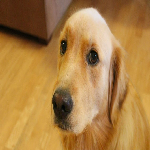

In [15]:
get_image(path1, (img_width, img_height))

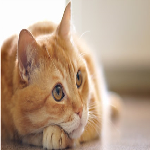

In [14]:
get_image(path2, (img_width, img_height))